# Predicción de Tráfico de Internet con ConvLSTM

## ¿Qué es ConvLSTM?
El modelo **ConvLSTM** (Convolutional Long Short-Term Memory) es una evolución de las redes recurrentes diseñada específicamente para datos espaciotemporales. A diferencia de un LSTM estándar que usa multiplicaciones de matrices totalmente conectadas, el ConvLSTM utiliza **operaciones de convolución** en sus puertas.

## Ventajas de este enfoque
*   **Captura Espacial**: Las convoluciones permiten extraer patrones geográficos y vecindades (como una CNN).
*   **Memoria Temporal**: Las puertas LSTM permiten recordar patrones históricos a largo plazo.
*   **Eficiencia**: Al compartir pesos mediante convoluciones, es más eficiente al tratar con imágenes/rejillas que un LSTM aplanado.

## Implementación en este Notebook
1.  **Arquitectura**: Una celda ConvLSTM personalizada que procesa secuencias de mapas de calor 2D.
2.  **Embeddings**: Integramos información de la hora y el día expandiéndolos como canales adicionales de información espacial.
3.  **Normalización**: Seguimos usando **Z-Score** para una convergencia óptima.


In [1]:
import torch.nn.functional as F
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (Internet) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de Internet (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.

Sea $X_t \in \mathbb{R}^{2 \times 100 \times 100}$ el tensor de tráfico en el tiempo $t$, donde el canal 0 representa `internetin` y el canal 1 representa `internetout`. El objetivo es aprender una función $f$ tal que:

$$ \hat{X}_{t} = f(X_{t-1}, X_{t-2}, \dots, X_{t-n}) $$

In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 1      # Canales (Total Internet Traffic)

# Parámetros de Entrenamiento
BATCH_SIZE = 8  # Reduced for VRAM (Accumulate to 32)
EPOCHS = 100
LEARNING_RATE = 0.001

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


## 2. Preprocesamiento de Datos

### 2.1. Agregación Espacio-Temporal
Los datos se agregan espacialmente en una rejilla de $(H 	imes W)$ y temporalmente en intervalos de 1 hora.

### 2.2. Normalización Z-Score (Estandarización)
Sí, la **Z-Score** es mejor para este tipo de datos porque el tráfico de Internet suele tener distribuciones con colas largas (picos de uso) y outliers. La estandarización centra los datos en 0 y escala la varianza a 1, lo que ayuda a la red neuronal a converger más rápido y manejar mejor los valores atípicos que Min-Max (que comprime todo el rango si hay un outlier muy grande).

La transformación aplicada es:

$$ X_{norm} = \frac{X - \mu}{\sigma + \epsilon} $$

Donde:
*   $X$: Valor de tráfico original (Volumen).
*   $\mu$: Media global del conjunto de entrenamiento.
*   $\sigma$: Desviación estándar del conjunto de entrenamiento.

Esto resulta en valores centrados en 0, donde valores positivos indican tráfico por encima de la media y negativos por debajo.


### 2.1. Construcción del Grafo (Grid to Graph)
Convertimos la rejilla de 100x100 en un grafo donde cada celda es un nodo conectado a sus vecinos (arriba, abajo, izquierda, derecha).

In [3]:

import scipy.sparse as sp

# --- CONSTRUCCIÓN DEL GRAFO (SPARSE / EDGE INDEX) ---
def get_edge_index(h, w):
    rows = []
    cols = []
    for r in range(h):
        for c in range(w):
            idx = r * w + c
            # Vecinos: arriba, abajo, izq, der
            if r > 0: 
                rows.append((r-1)*w + c); cols.append(idx)
            if r < h-1: 
                rows.append((r+1)*w + c); cols.append(idx)
            if c > 0: 
                rows.append(r*w + c - 1); cols.append(idx)
            if c < w-1: 
                rows.append(r*w + c + 1); cols.append(idx)
                
    # Retornamos Tensor [2, E]
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return edge_index

print("Construyendo lista de aristas (Sparse edge_index)...")
edge_index = get_edge_index(100, 100).to(DEVICE)
print(f"Edge Index Shape: {edge_index.shape}") # [2, ~40000]


Construyendo lista de aristas (Sparse edge_index)...
Edge Index Shape: torch.Size([2, 39600])


### 2.2. Normalización Z-Score


In [4]:
files = ['../data1.csv/data1.csv', '../data2.csv/data2.csv']
valid_files = [f for f in files if os.path.exists(f)]

print("Cargando y agregando datos (esto puede tardar)...")

# Cargar con Dask
ddf = dd.read_csv(valid_files, assume_missing=True)

# Convertir TimeInterval a datetime
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')

# Redondear a la hora (Agregación Temporal)
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# Seleccionar columnas de interés (Internet)
cols = ['Hour', 'GridID', 'internet']
ddf = ddf[cols]

# Agrupar por Hora y GridID
agg_task = ddf.groupby(['Hour', 'GridID'])[['internet']].sum()

with ProgressBar():
    df_agg = agg_task.compute().reset_index()

print("Agregación completada.")
print(df_agg.head())

Cargando y agregando datos (esto puede tardar)...
[########################################] | 100% Completed | 57.47 s
Agregación completada.
                 Hour  GridID    internet
0 2013-12-20 23:00:00   162.0   25.301784
1 2013-12-20 23:00:00   221.0   26.829943
2 2013-12-20 23:00:00   237.0   32.173460
3 2013-12-20 23:00:00   255.0  118.767578
4 2013-12-20 23:00:00   296.0    0.489291


In [5]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()jode
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 1, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['internet'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # internet
        vals = df_pivot.loc[t, 'internet'].reindex(range(1, 10001), fill_value=0).values
        data_tensor[idx, 0, :, :] = vals.reshape(100, 100)
print(f"Tensor shape: {data_tensor.shape}")
# --- RESHAPE FOR GNN [Time, Nodes, Features] ---
N = H * W
data_gnn = data_tensor.reshape(-1, N, 1) # [Time, 10000, 1]
print(f'GNN Data Shape (Time, Nodes, Feat): {data_gnn.shape}')


Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 1, 100, 100)
GNN Data Shape (Time, Nodes, Feat): (1488, 10000, 1)


In [6]:

# --- NORMALIZACIÓN Z-SCORE ---
traffic_mean = data_gnn.mean()
traffic_std = data_gnn.std()
print(f"Mean: {traffic_mean}, Std: {traffic_std}")

data_norm = (data_gnn - traffic_mean) / traffic_std
print(f"Min norm: {data_norm.min()}, Max norm: {data_norm.max()}")
             

Mean: 373.1783447265625, Std: 723.292724609375
Min norm: -0.515943706035614, Max norm: 55.13580322265625


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [7]:

# --- FAILSAFE FOR VARIABLES ---
import pandas as pd
import numpy as np

if 'time_feat_np' not in locals():
    print("WARNING: time_feat_np was missing. Attempting auto-reconstruction...")
    if 'time_range' not in locals():
        if 'df_agg' in locals():
            print("Reconstructing time_range from df_agg...")
            _min_t = df_agg['Hour'].min()
            _max_t = df_agg['Hour'].max()
            time_range = pd.date_range(_min_t, _max_t, freq='H')
        else:
            print("ERROR: df_agg is also missing. Please run the Data Loading cell (Section 2.1)!")
            
    if 'time_range' in locals():
        time_feat_np = np.stack([time_range.hour, time_range.dayofweek], axis=1)
        print(f"time_feat_np reconstructed. Shape: {time_feat_np.shape}")


#  GENERACIÓN DE DATASET

def create_gnn_dataset_optimized(data, time_data, len_c, len_p):
    # data: [Time, Nodes, Features]
    # time_data: [Time, 2] (Hour, Day)
    T, N, F = data.shape
    
    X, Time_Seq, Y = [], [], []
    
    start_idx = max(len_c, len_p * 24)
    
    print("Generando dataset GNN con Tiempo...")
    for i in range(start_idx, T):
        y = data[i] 
        
        # Sequence indices
        # Closeness
        idx_c = np.arange(i-len_c, i)
        
        # Period
        idx_p = []
        for p in range(len_p, 0, -1):
            idx_p.append(i - (p * 24))
        
        full_idx = np.concatenate([idx_p, idx_c]) # [Seq_Len]
        
        x_seq = data[full_idx] # [Seq_Len, N, F]
        t_seq = time_data[full_idx] # [Seq_Len, 2]
        
        X.append(x_seq)
        Time_Seq.append(t_seq)
        Y.append(y)
        
    return np.array(X), np.array(Time_Seq), np.array(Y)

print("Generando tensores X, T, Y...")
X, T_seq, Y = create_gnn_dataset_optimized(data_norm, time_feat_np, LEN_CLOSE, LEN_PERIOD)
print(f"X shape: {X.shape}, T shape: {T_seq.shape}")
            

time_feat_np reconstructed. Shape: (1488, 2)
Generando tensores X, T, Y...
Generando dataset GNN con Tiempo...
X shape: (1416, 6, 10000, 1), T shape: (1416, 6, 2)


In [8]:

# --- DIVISIÓN TRAIN / TEST ---
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

X_train, T_train, Y_train = X[:train_samples], T_seq[:train_samples], Y[:train_samples]
X_test, T_test, Y_test = X[train_samples:], T_seq[train_samples:], Y[train_samples:]

# Dataset includes time now
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(T_train).long(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(T_test).long(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
             


## 3. Arquitectura del Modelo: ConvLSTM (Spatio-Temporal Graph Neural Network)

El modelo combina **Convoluciones en Grafos (GCN)** para capturar dependencias espaciales y **LSTM** para dependencias temporales.

1.  **GCN Layer**: Procesa la información espacial usando la matriz de adyacencia.
    $$ H' = \sigma(\hat{A} H W) $$
2.  **LSTM Layer**: Procesa la secuencia temporal de características extraídas por la GCN para cada nodo.
3.  **Output Layer**: Predicción final para cada nodo.
             


## 3. Arquitectura Optimizada: Time-Aware ConvLSTM
Se introducen mejoras significativas:
1.  **Time Embeddings**: Capas de embedding para Hora y Día, concatenadas a las features de cada nodo.
2.  **GAT Layer**: Atención gráfica para ponderar vecinos dinámicamente. 
    *Nota: Se itera sobre el batch para evitar problemas de memoria (OOM) con grafos densos.*
             

In [9]:

import torch.nn as nn
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        # Gate convolutions: i, f, o, g
        self.conv = nn.Conv2d(in_channels + hidden_channels, 4 * hidden_channels, 
                              kernel_size=kernel_size, padding=self.padding)

    def forward(self, x, h, c):
        # x: [B, C_in, H, W]
        # h: [B, C_hidden, H, W]
        combined = torch.cat([x, h], dim=1)
        conv_output = self.conv(combined)
        
        # Split into 4 gates
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

class TimeAwareConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_dim, kernel_size, num_layers, seq_len):
        super(TimeAwareConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        # Embeddings de Tiempo
        self.emb_hour = nn.Embedding(24, 8) 
        self.emb_day = nn.Embedding(7, 4)   
        
        # Input real: Traffic(1) + Embeddings(12) = 13 canales
        total_in_channels = in_channels + 12
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            cur_in = total_in_channels if i == 0 else hidden_dim
            self.layers.append(ConvLSTMCell(cur_in, hidden_dim, kernel_size))
            
        self.fc = nn.Conv2d(hidden_dim, 1, kernel_size=1) # Salida: 1 canal (Tráfico)

    def forward(self, x, t):
        # x: [B, S, 1, H, W]
        # t: [B, S, 2]
        b, s, c, h, w = x.shape
        
        # 1. Preparar Embeddings
        # [B, S, 12]
        h_emb = self.emb_hour(t[:, :, 0])
        d_emb = self.emb_day(t[:, :, 1])
        t_emb = torch.cat([h_emb, d_emb], dim=2) 
        
        # Expandir embeddings a dimensiones espaciales: [B, S, 12, H, W]
        t_emb = t_emb.view(b, s, 12, 1, 1).expand(-1, -1, -1, h, w)
        
        # Concatenar con tráfico: [B, S, 13, H, W]
        x_in = torch.cat([x, t_emb], dim=2)
        
        # 2. Inicializar estados ocultos
        h_states = [torch.zeros(b, self.hidden_dim, h, w, device=x.device) for _ in range(self.num_layers)]
        c_states = [torch.zeros(b, self.hidden_dim, h, w, device=x.device) for _ in range(self.num_layers)]
        
        # 3. Paso Recurrente
        for time_step in range(s):
            cur_input = x_in[:, time_step, :, :, :]
            for i, layer in enumerate(self.layers):
                h_states[i], c_states[i] = layer(cur_input, h_states[i], c_states[i])
                cur_input = h_states[i]
        
        # 4. Predicción Final (usando el último estado oculto de la última capa)
        out = self.fc(h_states[-1])
        return out # [B, 1, H, W]

print("Instanciando Modelo ConvLSTM con alta precisión...")
model = TimeAwareConvLSTM(in_channels=1, hidden_dim=64, kernel_size=3, num_layers=2, seq_len=12).to(DEVICE)
print(model)


Instanciando Modelo ConvLSTM con alta precisión...
TimeAwareConvLSTM(
  (emb_hour): Embedding(24, 8)
  (emb_day): Embedding(7, 4)
  (layers): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(77, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fc): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


## 4. Entrenamiento

### 4.1. Función de Pérdida (Loss Function)
Se utiliza el Error Cuadrático Medio (MSE) entre la predicción y el valor real:

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{X}_t^{(i)} - X_t^{(i)} ||^2 $$

Donde $\theta$ son todos los parámetros aprendibles del modelo.

### 4.2. Optimizador
*   **Algoritmo**: Adam (Adaptive Moment Estimation).
*   **Learning Rate**: Se utiliza un esquema de decaimiento (MultiStepLR) que reduce la tasa de aprendizaje en épocas específicas (50 y 75) para refinar la convergencia.

/home/jorge/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iniciando entrenamiento ConvLSTM en: cuda


Epoch 1/100: 100%|█| 156/156 [00:07<00:00, 21.62it/s, loss=0.246


Epoch 1, Loss: 0.409696


Epoch 2/100: 100%|█| 156/156 [00:05<00:00, 26.78it/s, loss=0.223


Epoch 2, Loss: 0.172335


Epoch 3/100: 100%|█| 156/156 [00:05<00:00, 27.00it/s, loss=0.014


Epoch 3, Loss: 0.115397


Epoch 4/100: 100%|█| 156/156 [00:05<00:00, 28.37it/s, loss=0.084


Epoch 4, Loss: 0.088979


Epoch 5/100: 100%|█| 156/156 [00:05<00:00, 27.52it/s, loss=0.103


Epoch 5, Loss: 0.072831


Epoch 6/100: 100%|█| 156/156 [00:05<00:00, 27.09it/s, loss=0.071


Epoch 6, Loss: 0.062924


Epoch 7/100: 100%|█| 156/156 [00:05<00:00, 27.22it/s, loss=0.044


Epoch 7, Loss: 0.055811


Epoch 8/100: 100%|█| 156/156 [00:05<00:00, 27.17it/s, loss=0.057


Epoch 8, Loss: 0.048452


Epoch 9/100: 100%|█| 156/156 [00:05<00:00, 27.66it/s, loss=0.019


Epoch 9, Loss: 0.043729


Epoch 10/100: 100%|█| 156/156 [00:05<00:00, 27.50it/s, loss=0.03


Epoch 10, Loss: 0.040953


Epoch 11/100: 100%|█| 156/156 [00:05<00:00, 27.57it/s, loss=0.03


Epoch 11, Loss: 0.037612


Epoch 12/100: 100%|█| 156/156 [00:05<00:00, 27.62it/s, loss=0.03


Epoch 12, Loss: 0.035033


Epoch 13/100: 100%|█| 156/156 [00:05<00:00, 27.73it/s, loss=0.03


Epoch 13, Loss: 0.033408


Epoch 14/100: 100%|█| 156/156 [00:05<00:00, 27.60it/s, loss=0.02


Epoch 14, Loss: 0.031621


Epoch 15/100: 100%|█| 156/156 [00:05<00:00, 27.74it/s, loss=0.02


Epoch 15, Loss: 0.029826


Epoch 16/100: 100%|█| 156/156 [00:05<00:00, 27.69it/s, loss=0.04


Epoch 16, Loss: 0.028355


Epoch 17/100: 100%|█| 156/156 [00:05<00:00, 27.68it/s, loss=0.03


Epoch 17, Loss: 0.027836


Epoch 18/100: 100%|█| 156/156 [00:05<00:00, 27.76it/s, loss=0.02


Epoch 18, Loss: 0.026474


Epoch 19/100: 100%|█| 156/156 [00:05<00:00, 27.18it/s, loss=0.01


Epoch 19, Loss: 0.026056


Epoch 20/100: 100%|█| 156/156 [00:05<00:00, 27.65it/s, loss=0.03


Epoch 20, Loss: 0.026922


Epoch 21/100: 100%|█| 156/156 [00:05<00:00, 27.54it/s, loss=0.02


Epoch 21, Loss: 0.023800


Epoch 22/100: 100%|█| 156/156 [00:05<00:00, 27.58it/s, loss=0.03


Epoch 22, Loss: 0.023182


Epoch 23/100: 100%|█| 156/156 [00:05<00:00, 27.71it/s, loss=0.02


Epoch 23, Loss: 0.022268


Epoch 24/100: 100%|█| 156/156 [00:05<00:00, 27.70it/s, loss=0.02


Epoch 24, Loss: 0.022088


Epoch 25/100: 100%|█| 156/156 [00:05<00:00, 27.80it/s, loss=0.02


Epoch 25, Loss: 0.021587


Epoch 26/100: 100%|█| 156/156 [00:05<00:00, 27.63it/s, loss=0.01


Epoch 26, Loss: 0.021861


Epoch 27/100: 100%|█| 156/156 [00:05<00:00, 27.63it/s, loss=0.01


Epoch 27, Loss: 0.021677


Epoch 28/100: 100%|█| 156/156 [00:05<00:00, 27.65it/s, loss=0.01


Epoch 28, Loss: 0.020229


Epoch 29/100: 100%|█| 156/156 [00:05<00:00, 27.36it/s, loss=0.02


Epoch 29, Loss: 0.019849


Epoch 30/100: 100%|█| 156/156 [00:05<00:00, 27.47it/s, loss=0.01


Epoch 30, Loss: 0.019818


Epoch 31/100: 100%|█| 156/156 [00:05<00:00, 27.70it/s, loss=0.02


Epoch 31, Loss: 0.019853


Epoch 32/100: 100%|█| 156/156 [00:05<00:00, 27.61it/s, loss=0.02


Epoch 32, Loss: 0.019063


Epoch 33/100: 100%|█| 156/156 [00:05<00:00, 27.67it/s, loss=0.03


Epoch 33, Loss: 0.018543


Epoch 34/100: 100%|█| 156/156 [00:05<00:00, 27.80it/s, loss=0.02


Epoch 34, Loss: 0.018334


Epoch 35/100: 100%|█| 156/156 [00:05<00:00, 27.71it/s, loss=0.01


Epoch 35, Loss: 0.018259


Epoch 36/100: 100%|█| 156/156 [00:05<00:00, 26.98it/s, loss=0.00


Epoch 36, Loss: 0.018000


Epoch 37/100: 100%|█| 156/156 [00:05<00:00, 27.59it/s, loss=0.01


Epoch 37, Loss: 0.018141


Epoch 38/100: 100%|█| 156/156 [00:05<00:00, 27.45it/s, loss=0.02


Epoch 38, Loss: 0.018088


Epoch 39/100: 100%|█| 156/156 [00:05<00:00, 27.12it/s, loss=0.01


Epoch 39, Loss: 0.017218


Epoch 40/100: 100%|█| 156/156 [00:05<00:00, 26.92it/s, loss=0.01


Epoch 40, Loss: 0.017307


Epoch 41/100: 100%|█| 156/156 [00:05<00:00, 27.29it/s, loss=0.01


Epoch 41, Loss: 0.016997


Epoch 42/100: 100%|█| 156/156 [00:05<00:00, 26.86it/s, loss=0.02


Epoch 42, Loss: 0.017131


Epoch 43/100: 100%|█| 156/156 [00:05<00:00, 27.27it/s, loss=0.00


Epoch 43, Loss: 0.017072


Epoch 44/100: 100%|█| 156/156 [00:05<00:00, 27.52it/s, loss=0.01


Epoch 44, Loss: 0.016505


Epoch 45/100: 100%|█| 156/156 [00:05<00:00, 27.56it/s, loss=0.01


Epoch 45, Loss: 0.016563


Epoch 46/100: 100%|█| 156/156 [00:05<00:00, 27.29it/s, loss=0.01


Epoch 46, Loss: 0.016330


Epoch 47/100: 100%|█| 156/156 [00:05<00:00, 27.75it/s, loss=0.00


Epoch 47, Loss: 0.016085


Epoch 48/100: 100%|█| 156/156 [00:05<00:00, 27.80it/s, loss=0.01


Epoch 48, Loss: 0.015847


Epoch 49/100: 100%|█| 156/156 [00:05<00:00, 27.32it/s, loss=0.01


Epoch 49, Loss: 0.016053


Epoch 50/100: 100%|█| 156/156 [00:05<00:00, 27.32it/s, loss=0.01


Epoch 50, Loss: 0.015794


Epoch 51/100: 100%|█| 156/156 [00:05<00:00, 27.39it/s, loss=0.01


Epoch 51, Loss: 0.015691


Epoch 52/100: 100%|█| 156/156 [00:05<00:00, 27.83it/s, loss=0.01


Epoch 52, Loss: 0.015956


Epoch 53/100: 100%|█| 156/156 [00:05<00:00, 27.49it/s, loss=0.01


Epoch 53, Loss: 0.015426


Epoch 54/100: 100%|█| 156/156 [00:05<00:00, 27.70it/s, loss=0.01


Epoch 54, Loss: 0.015480


Epoch 55/100: 100%|█| 156/156 [00:05<00:00, 27.67it/s, loss=0.02


Epoch 55, Loss: 0.015124


Epoch 56/100: 100%|█| 156/156 [00:05<00:00, 27.58it/s, loss=0.00


Epoch 56, Loss: 0.015573


Epoch 57/100: 100%|█| 156/156 [00:05<00:00, 27.75it/s, loss=0.01


Epoch 57, Loss: 0.015735


Epoch 58/100: 100%|█| 156/156 [00:05<00:00, 27.85it/s, loss=0.01


Epoch 58, Loss: 0.015864


Epoch 59/100: 100%|█| 156/156 [00:05<00:00, 27.75it/s, loss=0.01


Epoch 59, Loss: 0.015372


Epoch 60/100: 100%|█| 156/156 [00:05<00:00, 27.66it/s, loss=0.01


Epoch 60, Loss: 0.014870


Epoch 61/100: 100%|█| 156/156 [00:05<00:00, 27.80it/s, loss=0.01


Epoch 61, Loss: 0.014804


Epoch 62/100: 100%|█| 156/156 [00:05<00:00, 27.78it/s, loss=0.01


Epoch 62, Loss: 0.014655


Epoch 63/100: 100%|█| 156/156 [00:05<00:00, 27.60it/s, loss=0.01


Epoch 63, Loss: 0.014735


Epoch 64/100: 100%|█| 156/156 [00:05<00:00, 27.78it/s, loss=0.02


Epoch 64, Loss: 0.014425


Epoch 65/100: 100%|█| 156/156 [00:05<00:00, 27.73it/s, loss=0.02


Epoch 65, Loss: 0.014330


Epoch 66/100: 100%|█| 156/156 [00:05<00:00, 27.44it/s, loss=0.01


Epoch 66, Loss: 0.014356


Epoch 67/100: 100%|█| 156/156 [00:05<00:00, 27.69it/s, loss=0.01


Epoch 67, Loss: 0.014523


Epoch 68/100: 100%|█| 156/156 [00:05<00:00, 27.73it/s, loss=0.01


Epoch 68, Loss: 0.014209


Epoch 69/100: 100%|█| 156/156 [00:05<00:00, 27.85it/s, loss=0.01


Epoch 69, Loss: 0.014369


Epoch 70/100: 100%|█| 156/156 [00:05<00:00, 27.66it/s, loss=0.01


Epoch 70, Loss: 0.013990


Epoch 71/100: 100%|█| 156/156 [00:05<00:00, 27.83it/s, loss=0.01


Epoch 71, Loss: 0.014072


Epoch 72/100: 100%|█| 156/156 [00:05<00:00, 27.91it/s, loss=0.01


Epoch 72, Loss: 0.014034


Epoch 73/100: 100%|█| 156/156 [00:05<00:00, 27.65it/s, loss=0.00


Epoch 73, Loss: 0.014268


Epoch 74/100: 100%|█| 156/156 [00:05<00:00, 27.73it/s, loss=0.01


Epoch 74, Loss: 0.014163


Epoch 75/100: 100%|█| 156/156 [00:05<00:00, 27.62it/s, loss=0.01


Epoch 75, Loss: 0.013809


Epoch 76/100: 100%|█| 156/156 [00:05<00:00, 27.70it/s, loss=0.01


Epoch 76, Loss: 0.013687


Epoch 77/100: 100%|█| 156/156 [00:05<00:00, 27.43it/s, loss=0.01


Epoch 77, Loss: 0.013654


Epoch 78/100: 100%|█| 156/156 [00:05<00:00, 27.81it/s, loss=0.01


Epoch 78, Loss: 0.013911


Epoch 79/100: 100%|█| 156/156 [00:05<00:00, 27.67it/s, loss=0.02


Epoch 79, Loss: 0.013990


Epoch 80/100: 100%|█| 156/156 [00:05<00:00, 27.19it/s, loss=0.01


Epoch 80, Loss: 0.014012


Epoch 81/100: 100%|█| 156/156 [00:05<00:00, 27.77it/s, loss=0.02


Epoch 81, Loss: 0.013632


Epoch 82/100: 100%|█| 156/156 [00:05<00:00, 27.72it/s, loss=0.01


Epoch 82, Loss: 0.013562


Epoch 83/100: 100%|█| 156/156 [00:05<00:00, 27.48it/s, loss=0.01


Epoch 83, Loss: 0.013766


Epoch 84/100: 100%|█| 156/156 [00:05<00:00, 27.67it/s, loss=0.00


Epoch 84, Loss: 0.013748


Epoch 85/100: 100%|█| 156/156 [00:05<00:00, 27.45it/s, loss=0.01


Epoch 85, Loss: 0.013589


Epoch 86/100: 100%|█| 156/156 [00:05<00:00, 27.38it/s, loss=0.01


Epoch 86, Loss: 0.013508


Epoch 87/100: 100%|█| 156/156 [00:05<00:00, 27.04it/s, loss=0.00


Epoch 87, Loss: 0.013688


Epoch 88/100: 100%|█| 156/156 [00:05<00:00, 27.77it/s, loss=0.01


Epoch 88, Loss: 0.014473


Epoch 89/100: 100%|█| 156/156 [00:05<00:00, 27.63it/s, loss=0.01


Epoch 89, Loss: 0.013322


Epoch 90/100: 100%|█| 156/156 [00:05<00:00, 27.53it/s, loss=0.00


Epoch 90, Loss: 0.013065


Epoch 91/100: 100%|█| 156/156 [00:05<00:00, 27.41it/s, loss=0.02


Epoch 91, Loss: 0.013291


Epoch 92/100: 100%|█| 156/156 [00:05<00:00, 27.63it/s, loss=0.01


Epoch 92, Loss: 0.013195


Epoch 93/100: 100%|█| 156/156 [00:05<00:00, 27.37it/s, loss=0.01


Epoch 93, Loss: 0.013209


Epoch 94/100: 100%|█| 156/156 [00:05<00:00, 27.50it/s, loss=0.00


Epoch 94, Loss: 0.013228


Epoch 95/100: 100%|█| 156/156 [00:05<00:00, 27.58it/s, loss=0.01


Epoch 95, Loss: 0.013118


Epoch 96/100: 100%|█| 156/156 [00:05<00:00, 27.75it/s, loss=0.01


Epoch 96, Loss: 0.013607


Epoch 97/100: 100%|█| 156/156 [00:05<00:00, 27.81it/s, loss=0.01


Epoch 97, Loss: 0.012814


Epoch 98/100: 100%|█| 156/156 [00:05<00:00, 27.38it/s, loss=0.01


Epoch 98, Loss: 0.012856


Epoch 99/100: 100%|█| 156/156 [00:05<00:00, 27.71it/s, loss=0.01


Epoch 99, Loss: 0.012654


Epoch 100/100: 100%|█| 156/156 [00:05<00:00, 27.73it/s, loss=0.0


Epoch 100, Loss: 0.012609


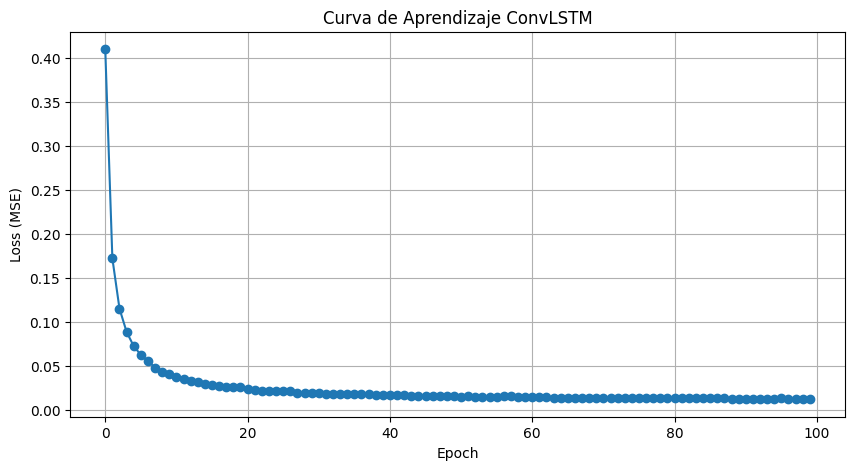

In [11]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
# --- ENTRENAMIENTO CONVLSTM (Optimizado) ---
# Configuración
ACCUMULATION_STEPS = 4
scaler = GradScaler()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
print(f"Iniciando entrenamiento ConvLSTM en: {DEVICE}")
train_losses = []
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    # Usamos tqdm.auto para que funcione bien en Jupyter/Notebooks
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    optimizer.zero_grad()
    for i, (x, t, y) in enumerate(pbar):
        # x: [B, S, N, 1] -> ConvLSTM necesita [B, S, C, H, W]
        b, s, n, f = x.shape
        h, w = 100, 100 # Dimensiones de la rejilla (100x100 = 10000 nodos)
        
        # Reshape: [B, S, 10000, 1] -> [B, S, 1, 100, 100]
        x = x.view(b, s, f, h, w).to(DEVICE)
        t, y = t.to(DEVICE), y.to(DEVICE)
        
        # y: [B, N, 1] -> [B, 1, H, W] para la pérdida
        y = y.view(b, 1, h, w)
        with autocast():
            output = model(x, t) # [B, 1, H, W]
            loss = criterion(output, y)
            loss = loss / ACCUMULATION_STEPS
        
        scaler.scale(loss).backward()
        
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        # Mostramos la pérdida actual en la barra
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.6f}"})
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")
    torch.cuda.empty_cache()
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o')
plt.title('Curva de Aprendizaje ConvLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de Internet).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en Internet).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Evaluando modelo (ConvLSTM)...


Testing: 100%|██████████████████| 21/21 [00:00<00:00, 37.17it/s]



Resultados de Evaluación (ConvLSTM):
RMSE: 58.4182
MAE:  24.9260
R2:   0.9753
WMAPE: 10.2821%
Accuracy: 89.7179%
Visualizando nodo con mayor tráfico: 5160


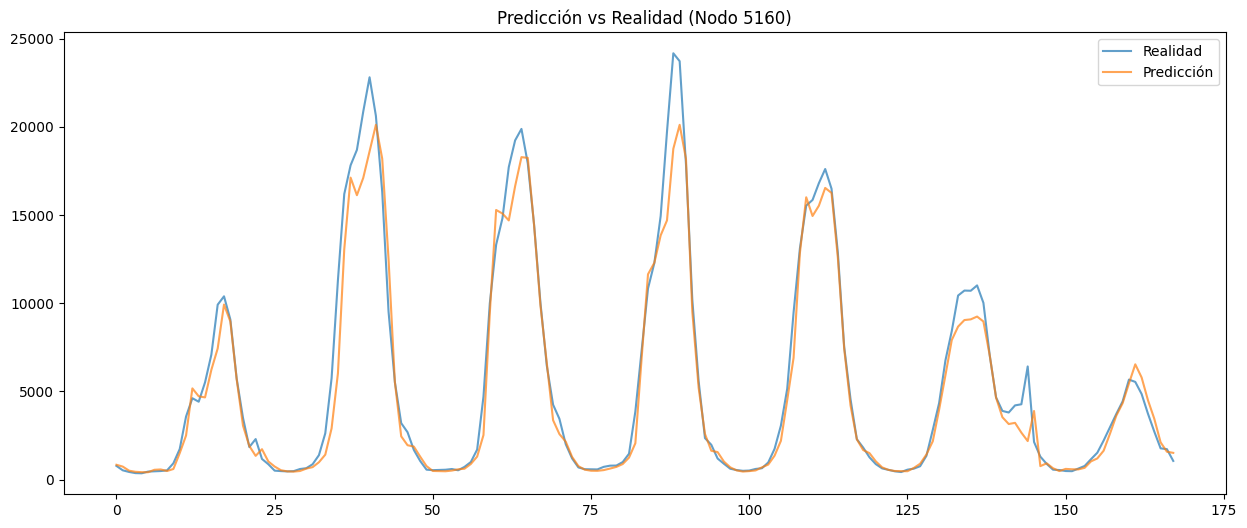

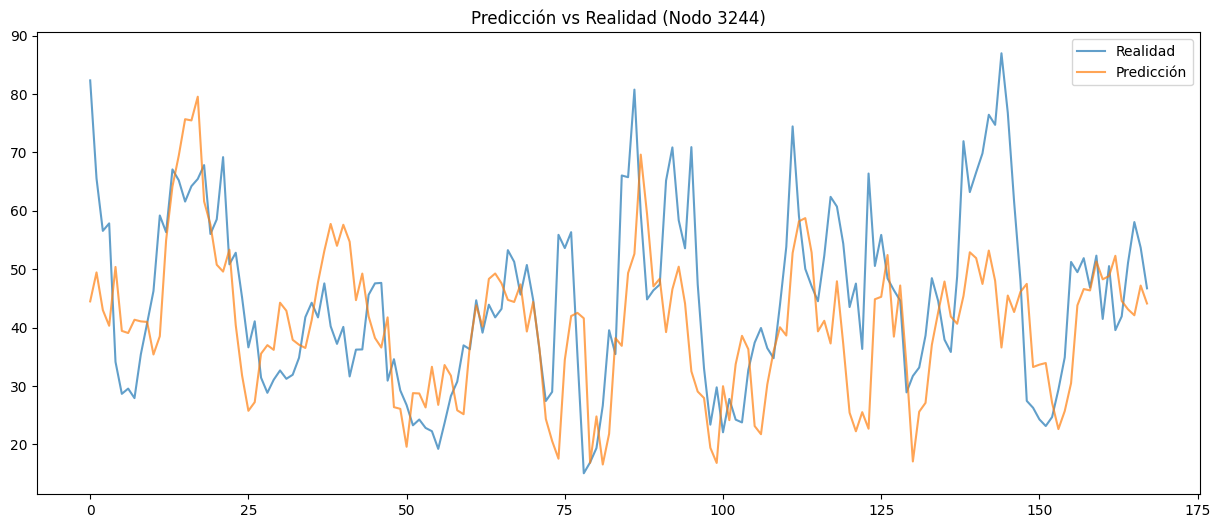

In [13]:
# --- EVALUACIÓN CORREGIDA ---
model.eval()
predictions = []
ground_truth = []

print("Evaluando modelo (ConvLSTM)...")
with torch.no_grad():
    for x, t, y in tqdm(test_loader, desc="Testing"):
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        
        # 1. CORRECCIÓN DE DIMENSIONES (Reshape)
        # El loader entrega [Batch, Seq, 10000, 1] -> ConvLSTM necesita [Batch, Seq, 1, 100, 100]
        if x.dim() == 4 and x.shape[2] == 10000:
            b, s, n, f = x.shape
            x = x.view(b, s, 1, 100, 100) # Reshape a grilla 100x100

        # 2. CORRECCIÓN DEL ERROR: Remover 'edge_index'
        # TimeAwareConvLSTM.forward(x, t) no acepta edge_index
        output = model(x, t)
        
        # 3. VOLVER A APLANAR SALIDA
        # Output sale como [Batch, 1, 100, 100] -> Convertir a [Batch, 10000, 1] para cuadrar con ground_truth
        if output.dim() == 4:
            b, c, h, w = output.shape
            output = output.view(b, h*w, c) # [B, 10000, 1]

        predictions.append(output.cpu().numpy())
        ground_truth.append(y.cpu().numpy())

preds = np.concatenate(predictions, axis=0)
gt = np.concatenate(ground_truth, axis=0)

# Denormalize (Z-Score)
# x = (x_norm * std) + mean
preds_orig = preds * traffic_std + traffic_mean
gt_orig = gt * traffic_std + traffic_mean

# Avoid negative predictions
preds_orig = np.maximum(preds_orig, 0)

# Flatten for metrics
preds_flat = preds_orig.flatten()
gt_flat = gt_orig.flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(gt_flat, preds_flat))
mae = mean_absolute_error(gt_flat, preds_flat)
r2 = r2_score(gt_flat, preds_flat)

# WMAPE
wmape = np.sum(np.abs(gt_flat - preds_flat)) / np.sum(np.abs(gt_flat))
accuracy = 1 - wmape

print("\nResultados de Evaluación (ConvLSTM):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")

# --- VISUALIZACIÓN ---
# Validar en un nodo aleatorio con alto tráfico
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo con mayor tráfico: {max_node_idx}")

plt.figure(figsize=(15, 6))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {max_node_idx})')
plt.legend()
plt.show()

# Random node
rand_node = np.random.randint(0, 10000)
plt.figure(figsize=(15, 6))
plt.plot(gt_orig[:, rand_node, 0], label='Realidad', alpha=0.7)
plt.plot(preds_orig[:, rand_node, 0], label='Predicción', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {rand_node})')
plt.legend()
plt.show()

## Interpretación de las Gráficas

### 1. Curva de Aprendizaje (Training Loss)
*   Muestra el **Error Cuadrático Medio (MSE)** en cada época.
*   Debe descender rápidamente al principio y estabilizarse.
*   Si la curva es plana desde el principio, indica problemas de aprendizaje (learning rate o gradientes).

### 2. Predicción vs Realidad (Nodo Max Tráfico)
*   Visualiza la serie temporal del **nodo con mayor carga promedio** de la red.
*   Es el "caso difícil" o crítico. Si el modelo predice bien aquí, es robusto.
*   **Azul**: Datos reales (Ground Truth).
*   **Naranja**: Predicción del modelo.

### 3. Grid de Celdas Aleatorias
*   Muestra 10 celdas elegidas al azar para verificar la generalización.
*   Permite ver si el modelo funciona bien en celdas con poco tráfico o patrones irregulares, no solo en las principales.
*   **Accuracy Local**: Se muestra la precisión (1 - WMAPE) específica para ese nodo en el título.



Resultados de Evaluación (ConvLSTM):
RMSE: 58.4182
MAE:  24.9260
R2:   0.9753
WMAPE: 10.2821%
Accuracy: 89.7179%
Visualizando nodo con mayor tráfico: 5160


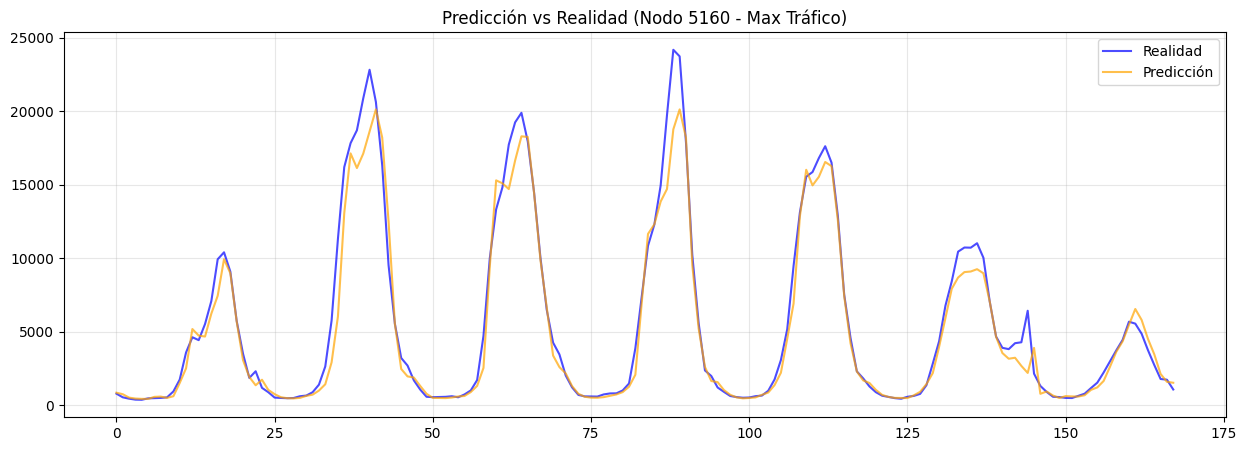

Visualizando 10 nodos aleatorios: [9266 6233 8287 8935 2284 1071 2973 6058  757  944]


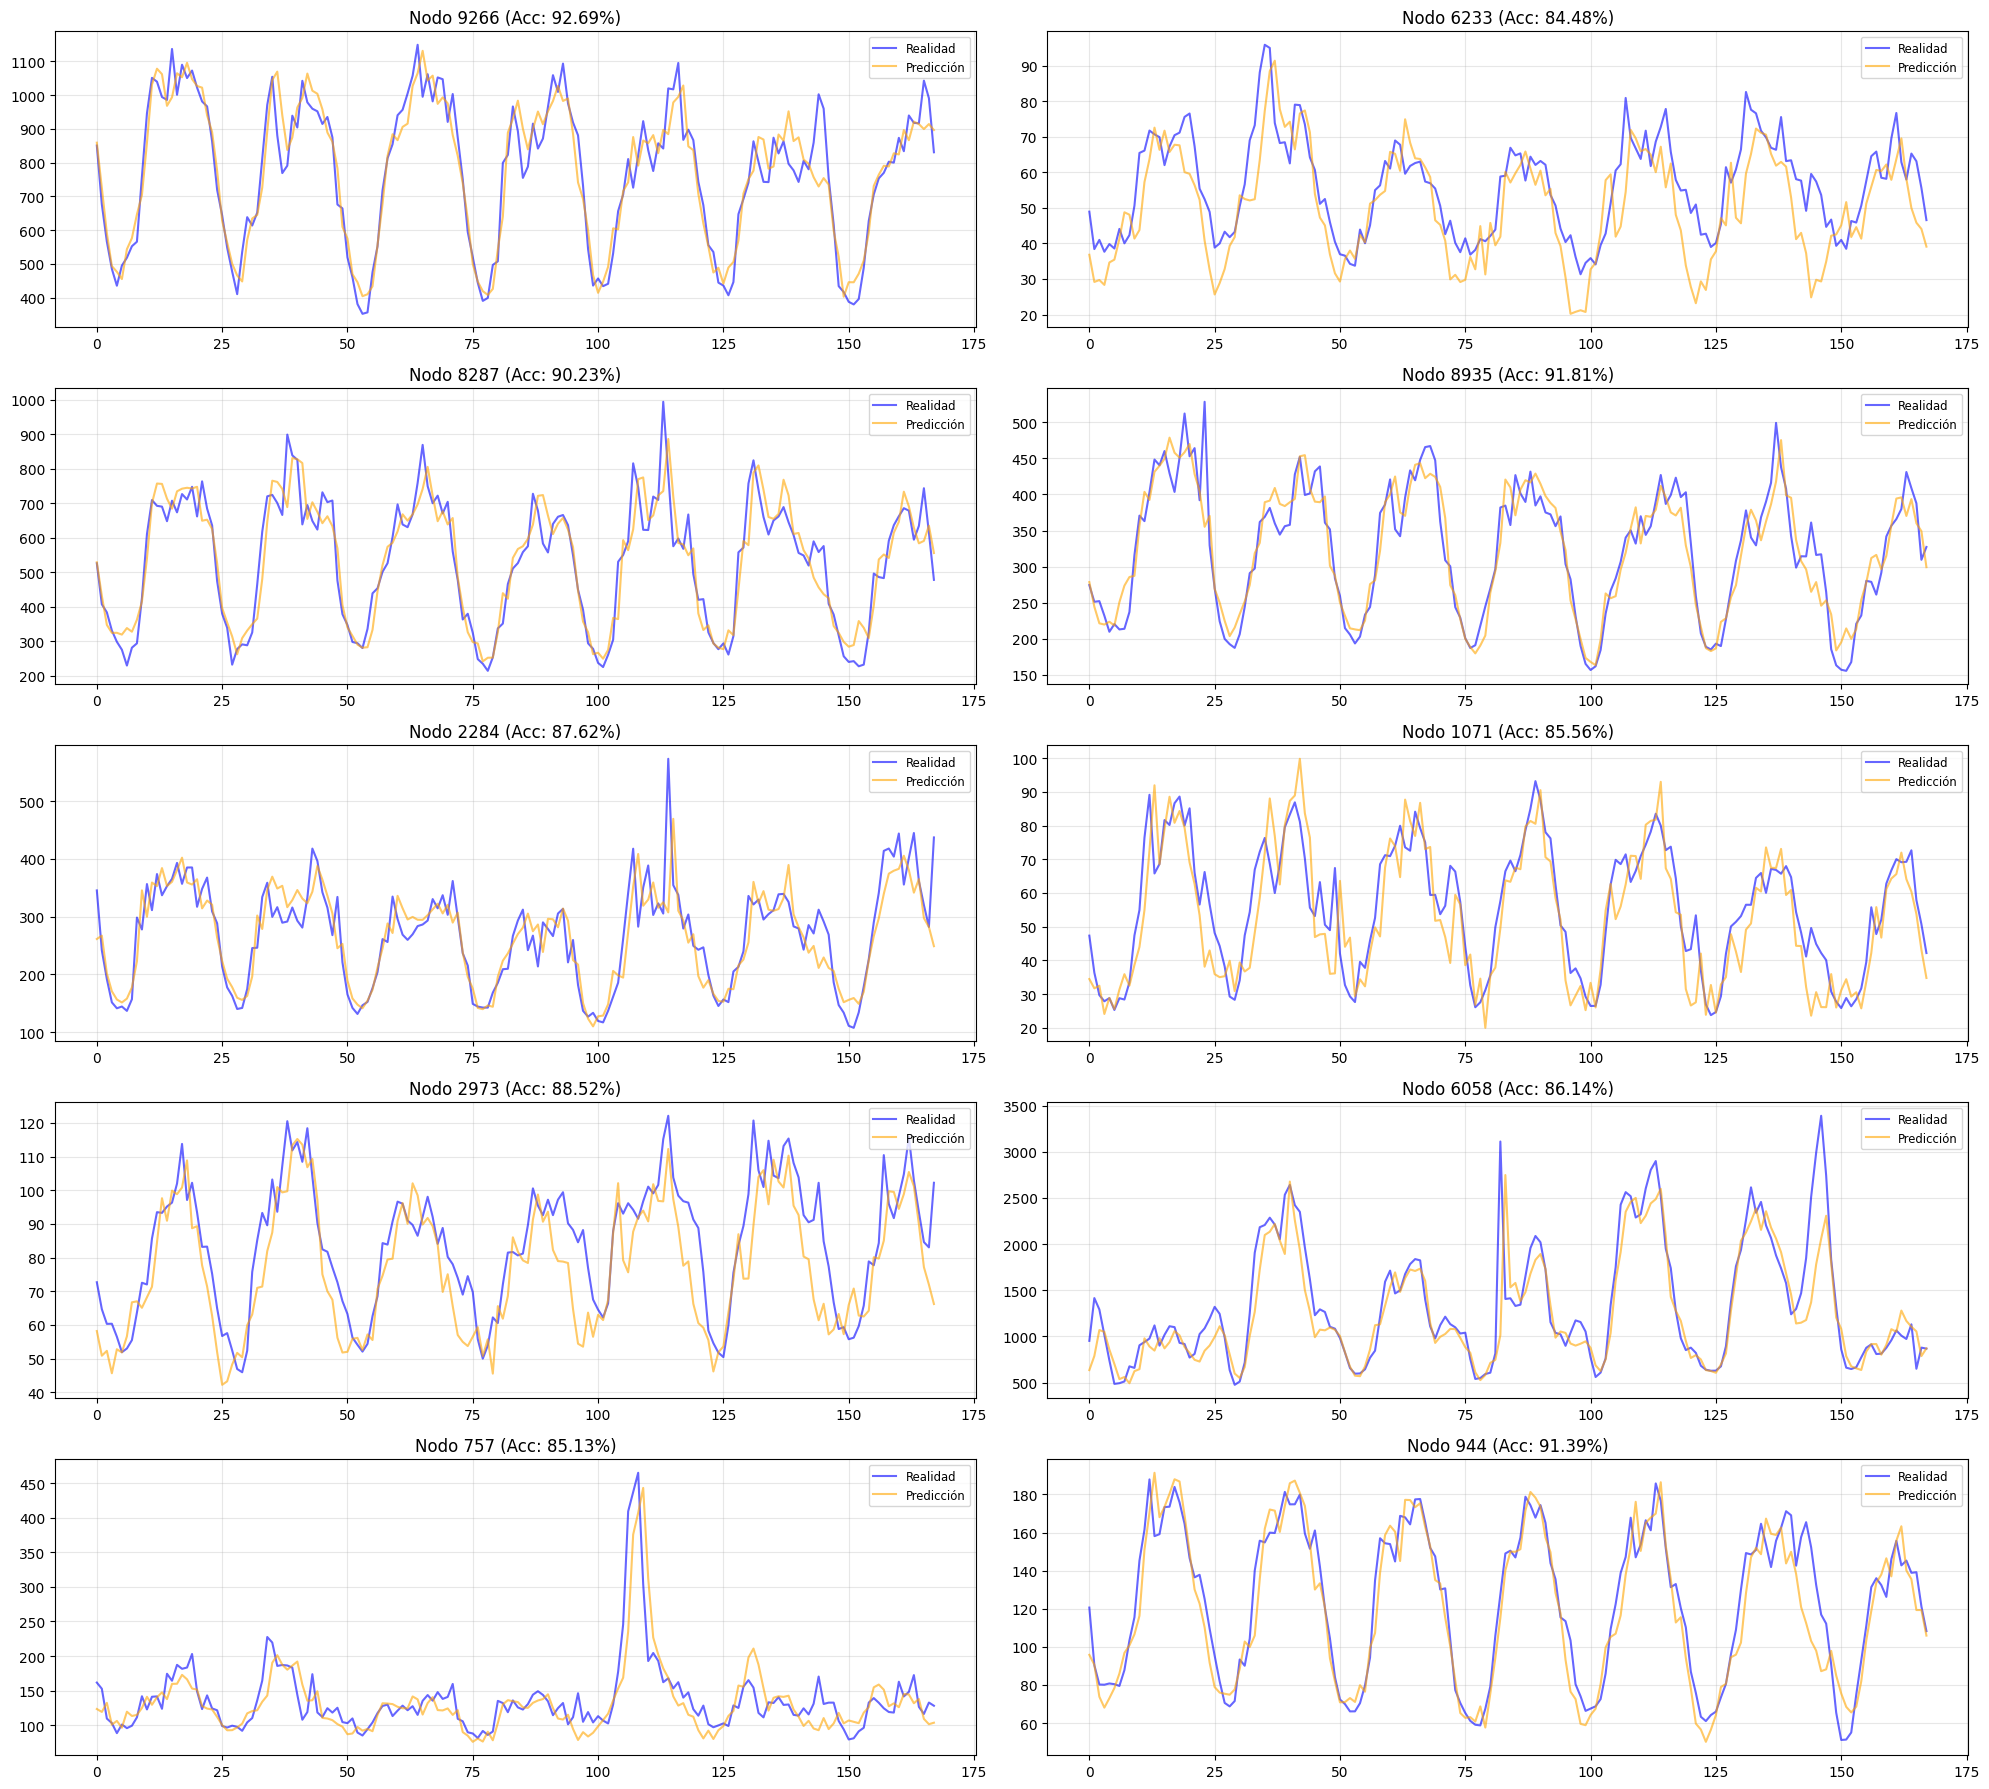

In [14]:
# ... (Tu código anterior de métricas: rmse, accuracy, etc.) ...
print("\nResultados de Evaluación (ConvLSTM):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")
# --- VISUALIZACIÓN MEJORADA (10 Aleatorios) ---
import matplotlib.pyplot as plt
# 1. Nodo con mayor tráfico (Siempre es bueno mantener la referencia del "peor caso" de carga)
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo con mayor tráfico: {max_node_idx}")
plt.figure(figsize=(15, 5))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', color='blue', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', color='orange', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {max_node_idx} - Max Tráfico)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# 2. Visualizar 10 Celdas Aleatorias
num_plots = 10
# Seleccionamos índices aleatorios (sin repetir)
random_indices = np.random.choice(gt_orig.shape[1], size=num_plots, replace=False)
print(f"Visualizando {num_plots} nodos aleatorios: {random_indices}")
# Creamos una figura grande con subplots (5 filas x 2 columnas)
fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.flatten()
for i, node_idx in enumerate(random_indices):
    ax = axes[i]
    ax.plot(gt_orig[:, node_idx, 0], label='Realidad', color='blue', alpha=0.6)
    ax.plot(preds_orig[:, node_idx, 0], label='Predicción', color='orange', alpha=0.6)
    
    # Métricas locales para este nodo (opcional, para ver qué tal va individualmente)
    local_acc = 1 - (np.sum(np.abs(gt_orig[:, node_idx] - preds_orig[:, node_idx])) / np.sum(np.abs(gt_orig[:, node_idx])))
    
    ax.set_title(f'Nodo {node_idx} (Acc: {local_acc:.2%})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:

# --- GUARDADO DEL MODELO ---
model_save_path = 'convlstm_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado exitosamente en: {model_save_path}")